# SO3

GTSAM Copyright 2010-2022, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved

Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

Typically, 3D rotations are used in GTSAM via the class [`Rot3`](Rot3.ipynb), which can use either `SO3` or `Quaternion` as the underlying representation.

`gtsam.SO3` is the 3x3 matrix representation of an element of SO(3), and implements all the Jacobians associated with the group structure.

This document documents some of the math involved.

`SO3` implements the exponential map and its inverse, as well as their Jacobians. For more information on Lie groups and their use here, see [GTSAM concepts](https://gtsam.org/notes/GTSAM-Concepts.html).

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/geometry/doc/SO3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install GTSAM and Plotly from pip if running in Google Colab
try:
    import google.colab
    %pip install --quiet gtsam-develop 
except ImportError:
    pass # Not in Colab

## The Exponential Map

The exponential map for $\text{SO}(3)$ converts a 3D rotation vector $\omega$ (corresponding to a Lie algebra element $[\boldsymbol{\omega}]_\times$ in $\mathfrak{so}(3)$) into a rotation matrix (Lie group element in $\text{SO}(3)$). I.e., we map a rotation vector $\boldsymbol{\omega} \in \mathbb{R}^3$ to a rotation matrix $R \in \text{SO}(3)$.

Given a rotation vector $\boldsymbol{\omega} = (\omega_x, \omega_y, \omega_z)$, define:

- The rotation axis as the unit vector:
  
  $$
  \hat{\omega} = \frac{\boldsymbol{\omega}}{\theta}, \quad \text{where } \theta = \|\boldsymbol{\omega}\|
  $$

- The skew-symmetric matrix $[\boldsymbol{\omega}]_\times$:

  $$
  [\boldsymbol{\omega}]_\times =
  \begin{bmatrix}
  0 & -\omega_z & \omega_y \\
  \omega_z & 0 & -\omega_x \\
  -\omega_y & \omega_x & 0
  \end{bmatrix}
  $$

Using Rodrigues' formula, the exponential map is:

$$
\exp([\boldsymbol{\omega}]_\times) = I + A [\boldsymbol{\omega}]_\times + B [\boldsymbol{\omega}]_\times^2
$$

which results in the rotation matrix:

$$
R = I + A [\boldsymbol{\omega}]_\times + B [\boldsymbol{\omega}]_\times^2
$$

where:
- $A = \sin\theta/\theta$
- $B = (1 - \cos\theta)/\theta^2$
- $ I $ is the $ 3 \times 3 $ identity matrix.
- $ \theta $ is the magnitude of the rotation vector (rotation angle).
- $ [\boldsymbol{\omega}]_\times $ represents the skew-symmetric matrix, the infinitesimal rotation generator.

For very small $ \theta $, we use the Taylor series approximation:

$$
R \approx I + [\boldsymbol{\omega}]_\times
$$

since $ \sin\theta \approx \theta$ and $ 1 - \cos\theta \approx \frac{\theta^2}{2} $.

## The logarithm map

The logarithm map for $ \text{SO}(3) $ is the inverse of the exponential map It converts a rotation matrix $ R \in SO(3) $ into a 3D rotation vector (corresponding to a Lie algebra element [\boldsymbol{\omega}]_\times in $ \mathfrak{so}(3) $).

Given a rotation matrix $ R $, the corresponding rotation vector $ \boldsymbol{\omega} \in \mathbb{R}^3 $ is computed as:

$$
\boldsymbol{\omega} = \theta \hat{\omega}
$$

where:
- $ \theta $ is the rotation angle:
  
  $$
  \theta = \cos^{-1} \left( \frac{\text{Tr}(R) - 1}{2} \right)
  $$

- $ \hat{\omega} $ is the rotation axis, obtained from the skew-symmetric matrix $ [\boldsymbol{\omega}]_\times $:

  $$
  [\boldsymbol{\omega}]_\times = \frac{\theta}{2 \sin\theta} (R - R^T)
  $$

- Extracting the components:

  $$
  \boldsymbol{\omega} =
  \frac{\theta}{2 \sin\theta} (R - R^T)^\vee
  $$

For small $ \theta $, we use the Taylor series approximation:

$$
\boldsymbol{\omega} \approx \frac{1}{2} (R - R^T)^\vee
$$

In both cases, $ (R - R^T)^\vee $ extracts the unique 3D vector from a skew-symmetric matrix:

$$
(R - R^T)^\vee=
\begin{bmatrix}
  R_{32} - R_{23} \\
  R_{13} - R_{31} \\
  R_{21} - R_{12}
  \end{bmatrix}
$$

where $ R_{ij} $ are the elements of $ R $.

## Deep Dive: SO(3) Jacobians

The Jacobians defined in SO3.h describe how small changes in the *so(3)* tangent space (represented by a 3-vector $\omega$) relate to small changes on the SO(3) manifold (represented by rotation matrices $R$). They are crucial for tasks like uncertainty propagation, state estimation (e.g., Kalman filtering), and optimization (e.g., bundle adjustment) involving rotations.

**Definitions:**

Let $\omega$ be a vector in the tangent space *so(3)*, $\theta = \|\omega\|$ be the rotation angle, and $\Omega = \omega^\wedge$ be the 3x3 skew-symmetric matrix corresponding to $\omega$. The key coefficients used are:

*   $A = \sin(\theta) / \theta$
*   $B = (1 - \cos(\theta)) / \theta^2$
*   $C = (1 - A) / \theta^2 = (\theta - \sin(\theta)) / \theta^3$
*   $D = (1 / \theta^2) (1 - A / (2 * B))$

Note: Taylor series expansions are used for these coefficients when $\theta$ is close to zero for numerical stability.

As explained in detail in [Jacobians.md](Jacobians.md), the exponential map and its Jacobians are implemented using a small "functor", `gtsam::so3::DexpFunctor`, implemented in `SO3.*`. It defines both a `Jacobian` and `InvJacobian` kernel, that implement both left and right variants. You instantiate `DexpFunctor` with the value of the rotation vector $\omega$.

### 1. Right Jacobian or "dexp" (`Jacobian().right()`)

*   **Formula:** $J_r(\omega) = I - B \Omega + C \Omega^2$
*   **Relationship to `Expmap`:** Relates a small change $\delta$ in the tangent space *so(3)* to the corresponding small rotation applied *on the right* on the manifold SO(3).
    $$
    \text{Exp}(\omega + \delta) ≈ \text{Exp}(\omega) \, \text{Exp}(J_r(\omega) \, \delta)
    $$
*   **Explanation:** This Jacobian maps a perturbation $\delta$ in the tangent space (at the origin) to the equivalent perturbation $\tau = J_r(\omega) \, \delta$ in the tangent space *at* $R = \text{Exp}(\omega)$, such that the change on the manifold corresponds to right multiplication by $\text{Exp}(\tau)$. It represents the derivative of the exponential map considering right-composition (`dexp`). Often associated with perturbations in the **body frame**.
*   **Synonyms:** Right Jacobian of Exp, `dexp`, Differential of Exp (right convention).

### 2. Left Jacobian (`Jacobian().left()`)

*   **Formula:** $J_l(\omega) = I + B \Omega + C \Omega^2$
*   **Relationship to `Expmap`:** Relates a small change $\delta$ in the tangent space *so(3)* to the corresponding small rotation applied *on the left* on the manifold SO(3).
    $$
    \text{Exp}(\omega + \delta) ≈ \text{Exp}(J_l(\omega) \, \delta) \, \text{Exp}(\omega)
    $$
*   **Explanation:** This Jacobian maps a perturbation $\delta$ in the tangent space (at the origin) to the equivalent perturbation $\tau = J_l(\omega) \, \delta$ in the tangent space *at* $R = \text{Exp}(\omega)$, such that the change on the manifold corresponds to left multiplication by $\text{Exp}(\tau)$. Often associated with perturbations in the **world frame**. Note that $J_l(\omega) = J_r(-omega)$.
*   **Synonyms:** Left Jacobian of Exp, Differential of Exp (left convention).

### 3. Inverse Right Jacobian or "invDexp" (`InvJacobian().right()`)

*   **Formula:** $J_r^{-1}(\omega) = I + 0.5 \Omega + D \Omega^2$
*   **Relationship to `Logmap`:** Relates a small rotation perturbation $\tau$ applied *on the right* of a rotation $R = \text{Exp}(\omega)$ back to the resulting change in the logarithm map vector (tangent space coordinates).
    $$
    \text{Log}(R \, \text{Exp}(\tau)) - \text{Log}(R) ≈ J_r^{-1}(\omega) \, \tau
    $$
*   **Explanation:** This Jacobian maps a small rotation increment $\tau$ (applied in the **body frame**, i.e., right multiplication) to the corresponding change in the *so(3)* coordinates $\omega$. It is the derivative of the logarithm map when considering right perturbations. This is frequently needed in optimization algorithms that parameterize updates using right perturbations.
*   **Synonyms:** Inverse Right Jacobian of Exp, `invDexp`, Right Jacobian of Log (often implied by context).

### 4. Inverse Left Jacobian (`InvJacobian().left()`)

*   **Formula:** $J_l^{-1}(\omega) = I - 0.5 \Omega + D \Omega^2$
*   **Relationship to `Logmap`:** Relates a small rotation perturbation $\tau$ applied *on the left* of a rotation $R = \text{Exp}(\omega)$ back to the resulting change in the logarithm map vector (tangent space coordinates).
    $$
    Log(\text{Exp}(\tau) * R) - \text{Log}(R) ≈ J_l^{-1}(\omega) \, \tau
    $$
*   **Explanation:** This Jacobian maps a small rotation increment $\tau$ (applied in the **world frame**, i.e., left multiplication) to the corresponding change in the *so(3)* coordinates $\omega$. It is the derivative of the logarithm map when considering left perturbations. Note that $J_l^{-1}(\omega) = J_r^{-1}(-\omega)$.
*   **Synonyms:** Inverse Left Jacobian of Exp, Left Jacobian of Log (often implied by context).

## GTSAM Convention

GTSAM updates (retractions) for $SO(3)$ in GTSAM are performed using **right multiplication**:
$$
R_{\text{new}} = R \cdot \text{Exp}(\delta)
$$
where $\delta \in \mathfrak{so}(3)$ is a tangent space increment,and hence we naturally uses the **right Jacobian $J_r(\omega)$** for the related derivatives.
This choice is also known as **right trivialization**. This means we relate the tangent space at any rotation `R` back to the tangent space at the identity (the Lie algebra `so(3)`) using the differential of right multiplication. 

Note that this choice is **left-invariant**, because we can multiply with an arbitrary rotation matrix $R'$ on the left above, on both sides, and the update would not be affected. This term is often used in control theory, referring to how error states are defined or how system dynamics evolve relative to a world frame.

Even with the right-multiplication convention, the left Jacobians (associated with world-frame perturbations, $R' = \text{Exp}(\tau) \cdot R$) are used in several other places, most notably in Building Jacobians for the $SE(3)$ group (`Pose3`).

## Numerical Behavior near $0$ and $\pi$

SO(3) Jacobian Coefficients Near Zero: Taylor Expansions

When working with the exponential map ($\text{Exp}$) and logarithm map ($\text{Log}$) for $SO(3)$, and especially their Jacobians, we encounter several coefficients that depend on the rotation angle $\theta = ||\omega||$, where $\omega \in \mathfrak{so}(3)$ is the tangent vector.

These coefficients appear in the formulas for the Jacobians and the $\text{Exp}$ map itself:
*   $\text{Exp}(\omega) = I + A \cdot W + B \cdot W^2$
*   $J_r(\omega) = I - B \cdot W + C \cdot W^2$ (Right Jacobian of Exp)
*   $J_l(\omega) = I + B \cdot W + C \cdot W^2$ (Left Jacobian of Exp)
*   $J_r^{-1}(\omega) = I + \frac{1}{2} W + D \cdot W^2$ (Inverse Right Jacobian)
*   $J_l^{-1}(\omega) = I - \frac{1}{2} W + D \cdot W^2$ (Inverse Left Jacobian)

where $W = \omega^\wedge$ is the skew-symmetric matrix corresponding to $\omega$.

The coefficients are defined as:
*   $A = \frac{\sin(\theta)}{\theta}$
*   $B = \frac{1 - \cos(\theta)}{\theta^2}$
*   $C = \frac{1 - A}{\theta^2} = \frac{\theta - \sin(\theta)}{\theta^3}$
*   $D = \frac{1 - \frac{A}{2B}}{\theta^2} = \frac{1}{ \theta^2} \left( 1 - \frac{\frac{\sin\theta}{\theta}}{2 \frac{1 - \cos\theta}{\theta^2}} \right) = \frac{1}{\theta^2} \left( 1 - \frac{\sin\theta}{2(1-\cos\theta)} \right)$

### The Problem Near $\theta = 0$

As the rotation angle $\theta$ approaches zero, the standard formulas for these coefficients become numerically unstable due to division by zero or indeterminate forms like $0/0$.
*   $A$: $\frac{\sin(0)}{0} \rightarrow \frac{0}{0}$
*   $B$: $\frac{1 - \cos(0)}{0^2} \rightarrow \frac{0}{0}$
*   $C$: $\frac{0 - \sin(0)}{0^3} \rightarrow \frac{0}{0}$
*   $D$: Involves $A$ and $B$.

Direct computation using floating-point arithmetic near $\theta=0$ leads to loss of precision or `NaN` results.

### The Solution: Taylor Series Expansions

To maintain numerical stability and accuracy near $\theta=0$, we replace the exact formulas with their Taylor series expansions around $\theta=0$. GTSAM's `ExpmapFunctor` and `DexpFunctor` use expansions including the $\theta^2$ term, which provides good accuracy for small angles.

*   $A = 1 - \frac{\theta^2}{6} + O(\theta^4)$
*   $B = \frac{1}{2} - \frac{\theta^2}{24} + O(\theta^4)$
*   $C = \frac{1}{6} - \frac{\theta^2}{120} + O(\theta^4)$
*   $D = \frac{1}{12} + \frac{\theta^2}{720} + O(\theta^4)$

Let's visualize how well these approximations work near $\theta=0$.

### SO(3) Jacobian Coefficients Near Singularities: GTSAM Calculation

This notebook visualizes how GTSAM's `DexpFunctor` calculates the Jacobian coefficients C and D near the singularities at $\theta = 0$ and $\theta = \pi$. It compares the values computed by GTSAM (which uses Taylor expansions in the singular regions) against the exact mathematical formulas.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gtsam
import math

# --- Constants from GTSAM
near_zero_threshold_sq = 1e-6
near_pi_threshold_sq = 1e-6

near_zero_threshold = np.sqrt(near_zero_threshold_sq)
near_pi_delta_threshold = np.sqrt(near_pi_threshold_sq) # delta = pi - theta

# --- Define Exact Calculation Functions (for comparison) ---
# Constants for exact limits
one_6th = 1.0 / 6.0
one_12th = 1.0 / 12.0

def A_exact(theta):
    theta = np.asarray(theta)
    return np.divide(np.sin(theta), theta, out=np.ones_like(theta), where=(theta != 0))

def B_exact(theta):
    theta = np.asarray(theta)
    theta2 = theta**2
    # Stable 1-cos using 2*sin^2(theta/2)
    sin_half_theta = np.sin(theta / 2.0)
    one_minus_cos = 2.0 * sin_half_theta**2
    return np.divide(one_minus_cos, theta2, out=np.full_like(theta, 0.5), where=(theta2 != 0))

def C_exact(theta):
    theta = np.asarray(theta)
    theta2 = theta**2
    a = A_exact(theta)
    # Limit C -> 1/6 as theta -> 0
    return np.divide(1.0 - a, theta2, out=np.full_like(theta, one_6th), where=(theta2 != 0))

def D_exact(theta):
    theta = np.asarray(theta)
    theta2 = theta**2
    a = A_exact(theta)
    b = B_exact(theta)
    # Avoid division by zero if b is zero away from theta=0 (unlikely)
    # Use np.isclose for safer check near zero? But b should be ~0.5 near theta=0
    safe_b = np.where(np.abs(b) < 1e-20, 1e-20, b)
    term = 1.0 - a / (2.0 * safe_b)
    # Limit D -> 1/12 as theta -> 0
    return np.divide(term, theta2, out=np.full_like(theta, one_12th), where=(theta2 != 0))
# --- End Exact Functions ---

# --- Helper Function to Get GTSAM Coefficients ---
def get_gtsam_coeffs(theta_values):
    """Calculates coefficients A,B,C,D using GTSAM DexpFunctor."""
    gtsam_A, gtsam_B, gtsam_C, gtsam_D = [], [], [], []
    for theta in theta_values:
        if theta == 0: # Handle exact zero case if needed
             omega = np.array([0.0, 0.0, 0.0])
        else:
             # Use a simple axis, magnitude is theta
             omega = np.array([theta, 0.0, 0.0])
        try:
            # Instantiate the functor using the Vector3 omega
            # Assuming default C++ thresholds match the python ones above
            # Pass thresholds explicitly if constructor allows, e.g.:
            local = gtsam.so3.DexpFunctor(omega, 1, 1)

            # Store computed coefficients (ensure wrapper exposes these!)
            gtsam_A.append(local.A)
            gtsam_B.append(local.B)
            gtsam_C.append(local.C())
            gtsam_D.append(local.D())
        except Exception as e:
            print(f"Error processing theta={theta}: {e}")
            # Pad with NaN or handle error appropriately
            gtsam_A.append(np.nan)
            gtsam_B.append(np.nan)
            gtsam_C.append(np.nan)
            gtsam_D.append(np.nan)
    return (np.array(gtsam_A), np.array(gtsam_B),
            np.array(gtsam_C), np.array(gtsam_D))

def get_exact_coeffs(theta_values):
    """Calculates exact coefficients A,B,C,D."""
    return (A_exact(theta_values), B_exact(theta_values),
            C_exact(theta_values), D_exact(theta_values))

def plot_comparison(axs, theta_vals, gtsam_coeff, exact_coeff, coeff_name, threshold):
    """Helper to plot value and difference."""
    # Value Plot
    axs[0].semilogx(theta_vals, gtsam_coeff, '.', markersize=2, label=f'GTSAM {coeff_name}')
    axs[0].semilogx(theta_vals, exact_coeff, '--', linewidth=1, label=f'Exact {coeff_name}')
    grid_which = 'both' # Use 'both' for major/minor on log scale

    if threshold is not None:
      axs[0].axvline(threshold, color='r', linestyle=':', label=f'Threshold $\\theta \\approx {threshold:.2e}$') # Consistent threshold format
    axs[0].set_ylabel(f'Value of {coeff_name}')
    axs[0].set_title(f'Coefficient {coeff_name}')
    axs[0].legend(fontsize='small')
    axs[0].grid(True, which=grid_which)

    # Difference Plot
    diff = np.abs(gtsam_coeff - exact_coeff)
    # Avoid log(0) or very small values for plotting differences
    diff = np.maximum(diff, 1e-20)

    axs[1].loglog(theta_vals, diff, 'r.', markersize=2)
    axs[1].set_xscale('log') # Ensure x-axis is log
    axs[1].set_yscale('log') # Ensure y-axis is log

    if threshold is not None:
        axs[1].axvline(threshold, color='r', linestyle=':')
    axs[1].set_ylabel('Abs. Difference |GTSAM - Exact|')
    axs[1].set_title(f'Difference for {coeff_name}')
    axs[1].grid(True, which=grid_which)

### Visualization Near Zero ($\theta \approx 0$)

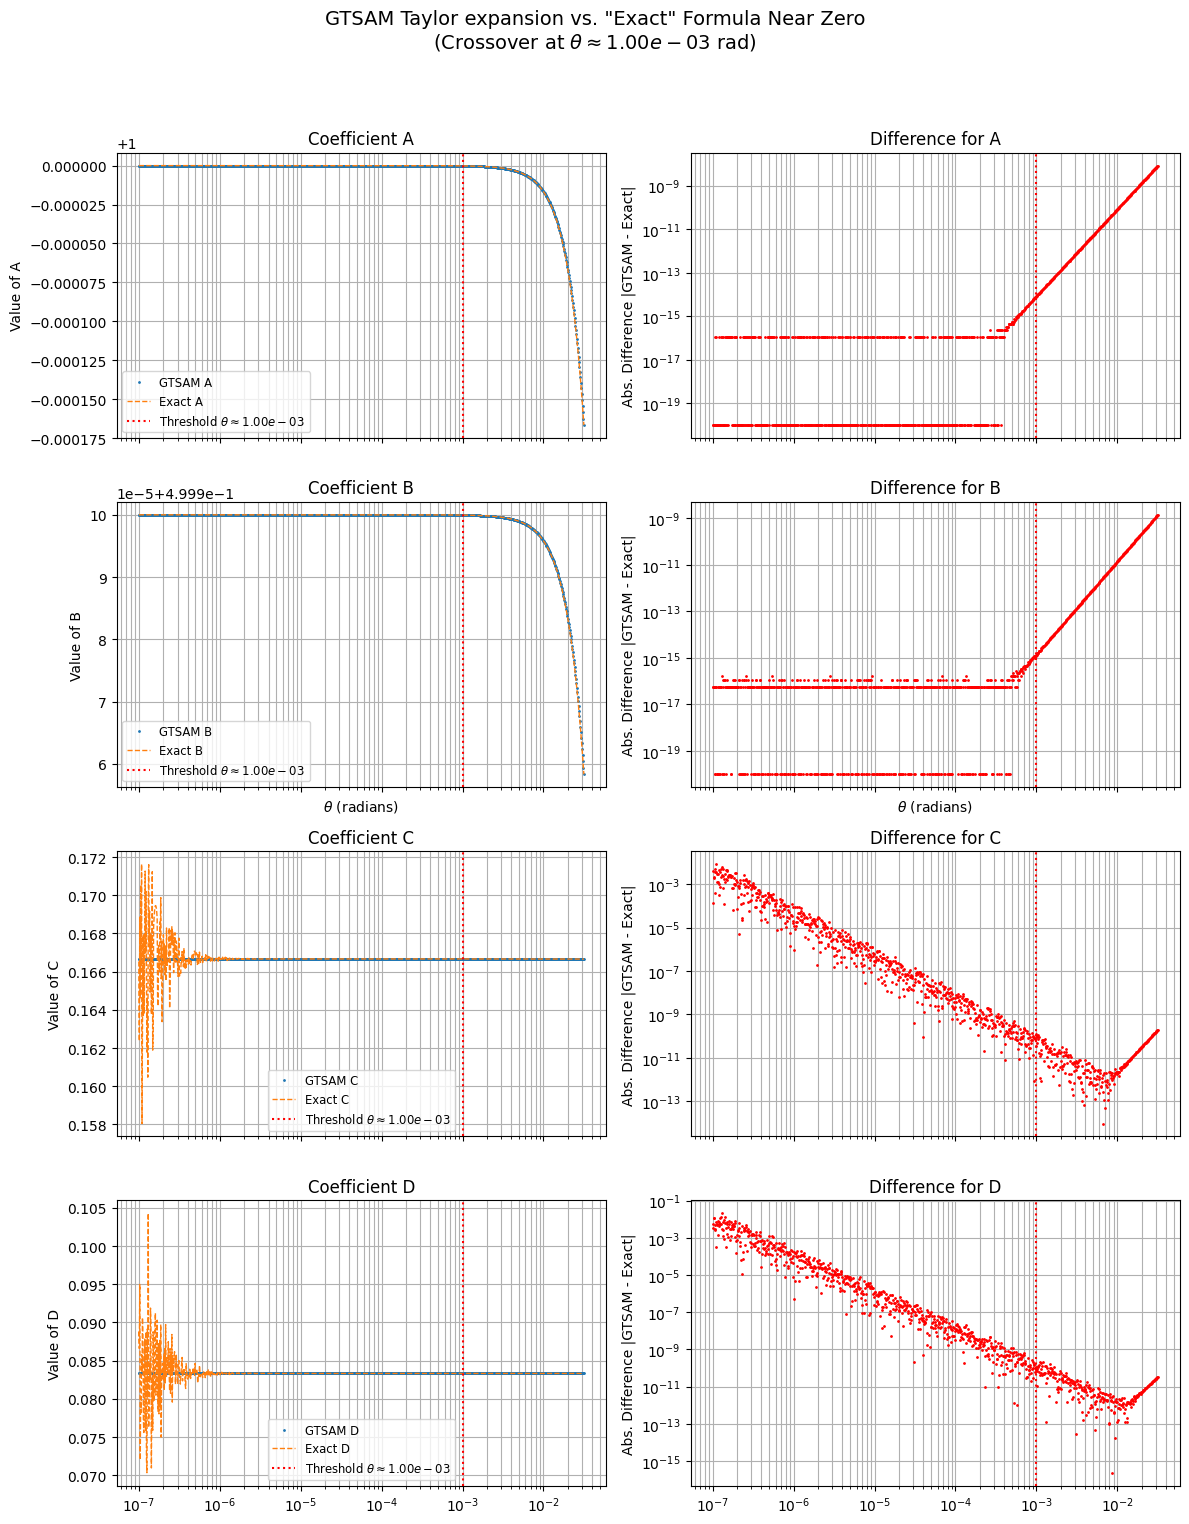

In [3]:
# Generate theta values on a log scale near zero
theta_vals_zero = np.logspace(-7, -1.5, 1000) # From 1e-7 up to ~ 1.8 degrees

# Calculate coefficients
gtsam_A_z, gtsam_B_z, gtsam_C_z, gtsam_D_z = get_gtsam_coeffs(theta_vals_zero)
exact_A_z, exact_B_z, exact_C_z, exact_D_z = get_exact_coeffs(theta_vals_zero)

# Plot C and D near Zero
fig_zero, axs_zero = plt.subplots(4, 2, figsize=(12, 16), sharex=True)
fig_zero.suptitle(f'GTSAM Taylor expansion vs. "Exact" Formula Near Zero\n(Crossover at $\\theta \\approx {near_zero_threshold:.2e}$ rad)', fontsize=14)

plot_comparison(axs_zero[0,:], theta_vals_zero, gtsam_A_z, exact_A_z, 'A', near_zero_threshold)
plot_comparison(axs_zero[1,:], theta_vals_zero, gtsam_B_z, exact_B_z, 'B', near_zero_threshold)
plot_comparison(axs_zero[2,:], theta_vals_zero, gtsam_C_z, exact_C_z, 'C', near_zero_threshold)
plot_comparison(axs_zero[3,:], theta_vals_zero, gtsam_D_z, exact_D_z, 'D', near_zero_threshold)

axs_zero[1, 0].set_xlabel("$\\theta$ (radians)")
axs_zero[1, 1].set_xlabel("$\\theta$ (radians)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

**Interpretation Near Zero:**
The plots show the *Taylor expansion* values computed by GTSAM (`.` markers) and the "exact" mathematical formulas (`--` lines). The red dotted line indicates the threshold $\theta = \sqrt{10^{-5}} \approx 0.00316$ radians.

For A and B, the difference plot shows that the Taylor expansion introduces a small approximation error below the threshold. The error increases as $\theta$ moves away from 0. ForC and D the exact formula is itself hard to compute accurately, but we see that the error of the Taylor expansion starts going up only far from the threshold. 

## Visualization Near Pi ($\theta \approx \pi$)
GTSAM specifically uses a Taylor expansion for coefficient **D** near $\pi$, as the standard formula becomes unstable. Other coefficients (A, B, C) are typically computed using their standard, stable forms near $\pi$.

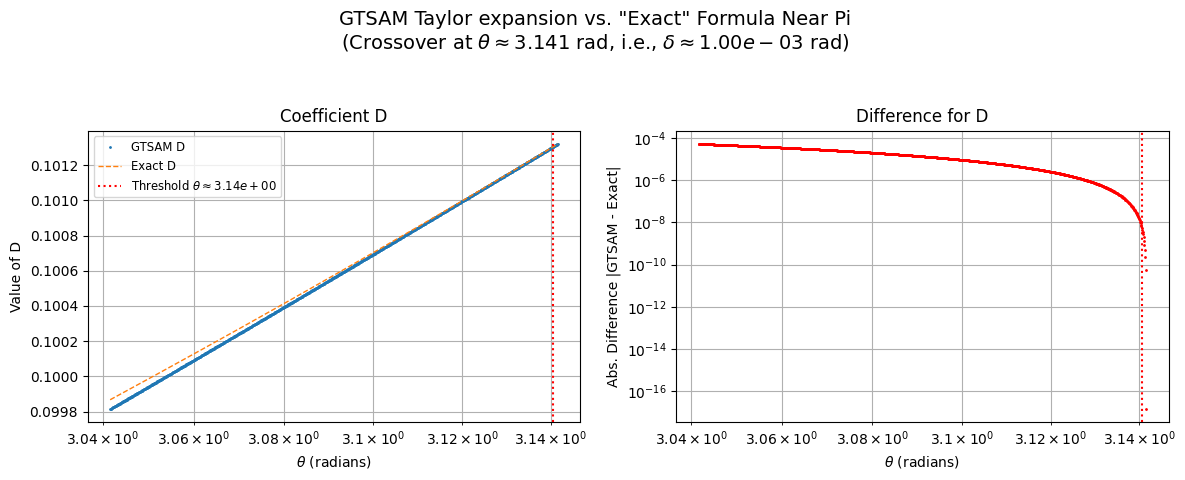

In [4]:
# Generate theta values on a linear scale near pi
theta_vals_pi = np.linspace(
    math.pi - 0.1, math.pi - 1e-9, 1000
)  # Approach pi from below, up to ~6 deg away

# Calculate coefficients
gtsam_A_p, gtsam_B_p, gtsam_C_p, gtsam_D_p = get_gtsam_coeffs(theta_vals_pi)
exact_A_p, exact_B_p, exact_C_p, exact_D_p = get_exact_coeffs(theta_vals_pi)

# Calculate the theta value corresponding to the delta threshold
near_pi_theta_threshold = math.pi - near_pi_delta_threshold

# Plot only D near Pi
fig_pi, axs_pi = plt.subplots(1, 2, figsize=(12, 5))
fig_pi.suptitle(
    r'GTSAM Taylor expansion vs. "Exact" Formula Near Pi'
    + f"\n(Crossover at $\\theta \\approx {near_pi_theta_threshold:.3f}$ rad, i.e., $\\delta \\approx {near_pi_delta_threshold:.2e}$ rad)",
    fontsize=14,
)

plot_comparison(axs_pi, theta_vals_pi, gtsam_D_p, exact_D_p, "D", near_pi_theta_threshold)

axs_pi[0].set_xlabel("$\\theta$ (radians)")
axs_pi[1].set_xlabel("$\\theta$ (radians)")
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

**Interpretation Near Pi:**
The plots focus on coefficient D as $\theta$ approaches $\pi$. The red dotted line indicates the threshold $\theta = \pi - \sqrt{10^{-3}} \approx \pi - 0.0316$ radians.

We only plot the Taylor expansion. To the right of the threshold (closer to $\pi$) GTSAM will use this, and the difference plot shows the approximation error introduced by this Taylor expansion is small (less than $10e-8$).